In [1]:
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.backend import l2_normalize
from keras.layers import *
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from skimage import transform
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Embedding
import os

Using TensorFlow backend.


In [15]:
def convnet_model_():
    vgg_model = VGG16(weights=None, include_top=False)
    x = vgg_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.6)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.6)(x)
    x = Lambda(lambda  x_: l2_normalize(x,axis=1))(x)
    convnet_model = Model(inputs=vgg_model.input, outputs=x)
    return convnet_model

def convnet_model():
    vgg_model = VGG16(weights=None, include_top=False)
    x = vgg_model.output
    x - GlobalAveragePooling2D()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.6)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.6)(x)
    
def deep_rank_model():
 
    convnet_model = convnet_model_()
    first_input = Input(shape=(224,224,3))
    first_conv = Conv2D(96, kernel_size=(8, 8),strides=(16,16), padding='same')(first_input)
    first_max = MaxPool2D(pool_size=(3,3),strides = (4,4),padding='same')(first_conv)
    first_max = Flatten()(first_max)
    first_max = Lambda(lambda  x: l2_normalize(x,axis=1))(first_max)

    second_input = Input(shape=(224,224,3))
    second_conv = Conv2D(96, kernel_size=(8, 8),strides=(32,32), padding='same')(second_input)
    second_max = MaxPool2D(pool_size=(7,7),strides = (2,2),padding='same')(second_conv)
    second_max = Flatten()(second_max)
    second_max = Lambda(lambda  x: l2_normalize(x,axis=1))(second_max)

    merge_one = concatenate([first_max, second_max])

    merge_two = concatenate([merge_one, convnet_model.output])
    emb = Dense(4096)(merge_two)
    l2_norm_final = Lambda(lambda  x: l2_normalize(x,axis=1))(emb)

    final_model = Model(inputs=[first_input, second_input, convnet_model.input], outputs=l2_norm_final)

    return final_model

def get_distance(model_name,positive_image,query_image):

    convnet_model = convnet_model_()
    first_input = Input(shape=(224,224,3))
    first_conv = Conv2D(96, kernel_size=(8, 8),strides=(16,16), padding='same')(first_input)
    first_max = MaxPool2D(pool_size=(3,3),strides = (4,4),padding='same')(first_conv)
    first_max = Flatten()(first_max)
    first_max = Lambda(lambda  x: l2_normalize(x,axis=1))(first_max)

    second_input = Input(shape=(224,224,3))
    second_conv = Conv2D(96, kernel_size=(8, 8),strides=(32,32), padding='same')(second_input)
    second_max = MaxPool2D(pool_size=(7,7),strides = (2,2),padding='same')(second_conv)
    second_max = Flatten()(second_max)
    second_max = Lambda(lambda  x: l2_normalize(x,axis=1))(second_max)

    merge_one = concatenate([first_max, second_max])

    merge_two = concatenate([merge_one, convnet_model.output])
    emb = Dense(4096)(merge_two)
    l2_norm_final = Lambda(lambda  x: l2_normalize(x,axis=1))(emb)

    model = Model(inputs=[first_input, second_input, convnet_model.input], outputs=l2_norm_final)

    # model = deep_rank_model()

    model.load_weights(model_name)

    image1 = load_img(positive_image)
    image1 = img_to_array(image1).astype("float64")
    image1 = transform.resize(image1, (224, 224))
    image1 *= 1. / 255
    image1 = np.expand_dims(image1, axis = 0)

    embedding1 = model.predict([image1, image1, image1])[0]

    image2 = load_img(query_image)
    image2 = img_to_array(image2).astype("float64")
    image2 = transform.resize(image2, (224, 224))
    image2 *= 1. / 255
    image2 = np.expand_dims(image2, axis = 0)

    embedding2 = model.predict([image2,image2,image2])[0]

    distance = sum([(embedding1[idx] - embedding2[idx])**2 for idx in range(len(embedding1))])**(0.5)

    print ("The distance between query image " + query_image + " and candidate image " + positive_image + " is ", distance)

    return distance

In [2]:
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.backend import l2_normalize
from keras.layers import *
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from skimage import transform
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Embedding
import time
import os


def getSimilarImages(model_name: str, query_image: str, img_directory: str, K: int):
    image_score = {}
    topKimages = []
    for filename in os.listdir(img_directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            path = os.path.join(img_directory, filename)
            distance = get_distance(model_name, path ,query_image)
            image_score[path] = distance
        else:
            continue
    sorted_image_scores = {k:v for k, v in sorted(image_score.items(), key = lambda item: item[1])}
    count = 0
    for image in sorted_image_scores:
        if count >= K:
            break
        topKimages.append(image)
        count += 1
    return topKimages

Using TensorFlow backend.


In [3]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

model_name = 'deepranking-v2-150000.h5'
query_image = 'data\image-11.jpg'
img_directory = r'D:\SPRING-20\696-E\image-similarity\data'
K = 6
start_time = time.time() # Start Time
sorted_image_scores = getSimilarImages(model_name, query_image, img_directory, K)
print("Time to execute this function is ", time.time() - start_time) # End Time


The distance between query image data\image-11.jpg and candidate image D:\SPRING-20\696-E\image-similarity\data\image-1.jpg is  0.7965714360728814
The distance between query image data\image-11.jpg and candidate image D:\SPRING-20\696-E\image-similarity\data\image-10.jpg is  0.5094821631627101
The distance between query image data\image-11.jpg and candidate image D:\SPRING-20\696-E\image-similarity\data\image-11.jpg is  0.0
The distance between query image data\image-11.jpg and candidate image D:\SPRING-20\696-E\image-similarity\data\image-12.jpg is  0.7122354846517955
The distance between query image data\image-11.jpg and candidate image D:\SPRING-20\696-E\image-similarity\data\image-13.jpg is  0.4649193657895612
The distance between query image data\image-11.jpg and candidate image D:\SPRING-20\696-E\image-similarity\data\image-14.jpg is  0.7962329242385698
The distance between query image data\image-11.jpg and candidate image D:\SPRING-20\696-E\image-similarity\data\image-15.jpg is 

Populating the interactive namespace from numpy and matplotlib

Query image: 



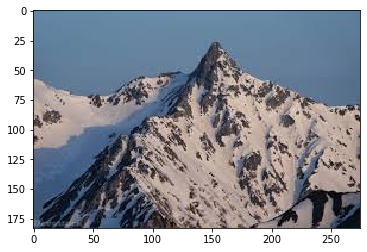

Results:



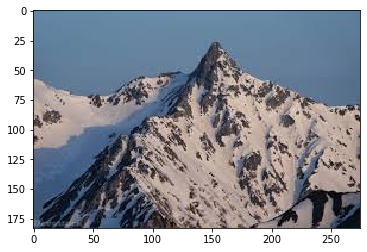

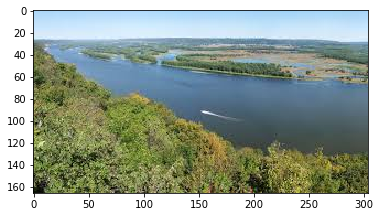

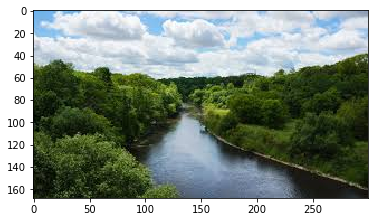

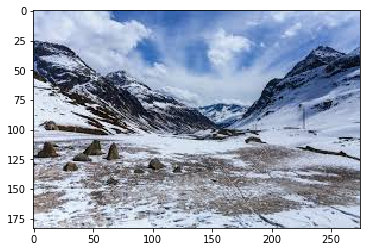

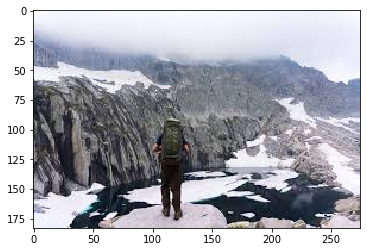

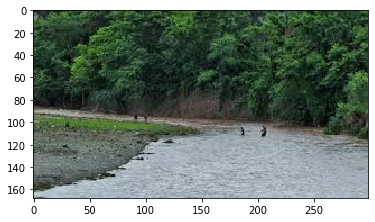

In [4]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print("\n"+color.BOLD + "Query image: " + color.END + "\n")
img=mpimg.imread(query_image)
imgplot = plt.imshow(img)
plt.show()
print(color.BOLD + "Results:" + color.END + "\n")
for image in sorted_image_scores:
    img=mpimg.imread(image)
    imgplot = plt.imshow(img)
    plt.show()

# New Approach

In [13]:
def getEmbedding(model_name, image_name):
    
    convnet_model = convnet_model_()
    first_input = Input(shape=(224,224,3))
    first_conv = Conv2D(96, kernel_size=(8, 8),strides=(16,16), padding='same')(first_input)
    first_max = MaxPool2D(pool_size=(3,3),strides = (4,4),padding='same')(first_conv)
    first_max = Flatten()(first_max)
    first_max = Lambda(lambda  x: l2_normalize(x,axis=1))(first_max)

    second_input = Input(shape=(224,224,3))
    second_conv = Conv2D(96, kernel_size=(8, 8),strides=(32,32), padding='same')(second_input)
    second_max = MaxPool2D(pool_size=(7,7),strides = (2,2),padding='same')(second_conv)
    second_max = Flatten()(second_max)
    second_max = Lambda(lambda  x: l2_normalize(x,axis=1))(second_max)

    merge_one = concatenate([first_max, second_max])

    merge_two = concatenate([merge_one, convnet_model.output])
    emb = Dense(4096)(merge_two)
    l2_norm_final = Lambda(lambda  x: l2_normalize(x,axis=1))(emb)

    model = Model(inputs=[first_input, second_input, convnet_model.input], outputs=l2_norm_final)

    # model = deep_rank_model()

    model.load_weights(model_name)

    image1 = load_img(image_name)
    image1 = img_to_array(image1).astype("float64")
    image1 = transform.resize(image1, (224, 224))
    image1 *= 1. / 255
    image1 = np.expand_dims(image1, axis = 0)

    embedding1 = model.predict([image1, image1, image1])[0]

    return embedding1


In [55]:
import json
import heapq
def generateEmbeddings(model_name, query_image, img_directory):
    img_embedding = {}
    filename = query_image.split('\\')
    filename = filename[-1]
    img_embedding[filename] = getEmbedding(model_name, query_image).tolist()
    for filename in os.listdir(img_directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(img_directory, filename)
            img_embedding[filename] = getEmbedding(model_name, img_path).tolist()
        else:
            continue
    with open("embeddings.json",'w') as f:
        j = json.dumps(img_embedding)
        f.write(j)
        f.close()

def getSimilarImages(query_image, embedding_file_path, img_directory, K):
    filename = query_image.split('\\')
    filename = filename[-1]
    embedding_dict = {}
    with open(embedding_file_path,'r') as f:
        embedding_dict = json.load(f)
    query_image_embedding = embedding_dict[filename]
    distance = {}
    for img in embedding_dict:
        if img!=filename:
            candidate_embedding = embedding_dict[img]
            distance[img] = sum([(query_image_embedding[idx] - candidate_embedding[idx])**2 for idx in range(len(query_image_embedding))])**(0.5)
    heap = [(value, key) for key,value in distance.items()]
    largestK = heapq.nsmallest(K, heap)
    largestK = [os.path.join(img_directory, key) for value, key in largestK]
    return largestK


In [56]:
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.backend import l2_normalize
from keras.layers import *
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from skimage import transform
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Embedding
import time
import os
import image_api

model_name = 'deepranking-v2-150000.h5'
query_image = 'data\image-14.jpg'
root_dir = r'D:\SPRING-20\696-E\image-similarity\output_dir'
class_dir = image_api.get_image_scene(query_image)
img_directory = root_dir+'\\'+class_dir
print(img_directory)
embedding_file_path = 'embeddings.json'
K = 20
# import gc
# gc.collect()

D:\SPRING-20\696-E\image-similarity\output_dir\snowfield


In [57]:
generateEmbeddings(model_name, query_image, img_directory)

In [58]:
import time
start_time = time.time()
sorted_image_scores = getSimilarImages(query_image, embedding_file_path, img_directory, K)
print("End time is ", time.time() - start_time)

End time is  0.07782459259033203


Populating the interactive namespace from numpy and matplotlib

Query image: 



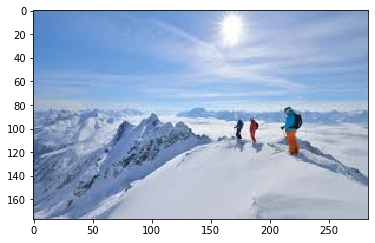

Results:



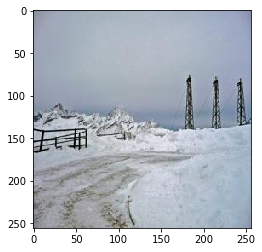

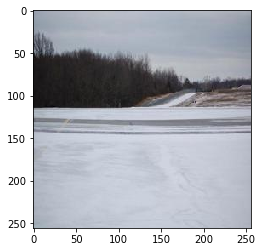

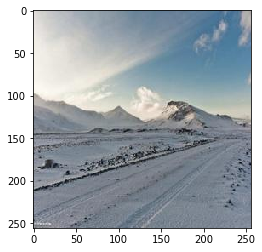

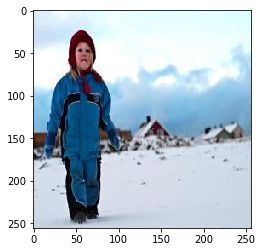

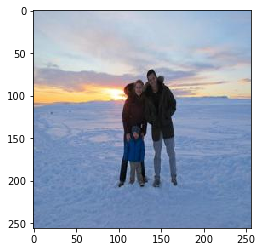

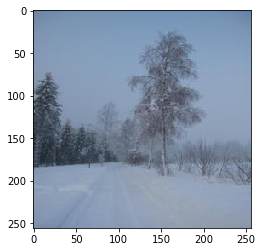

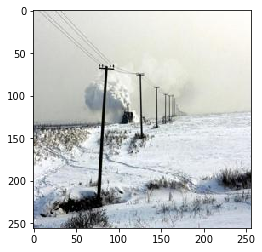

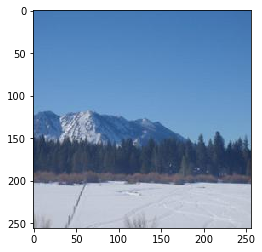

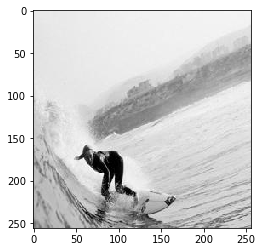

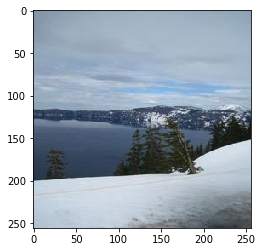

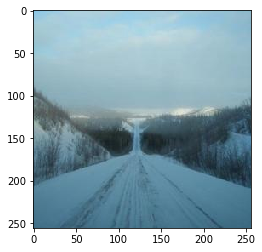

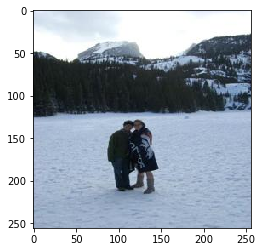

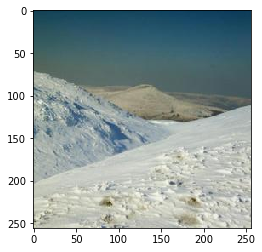

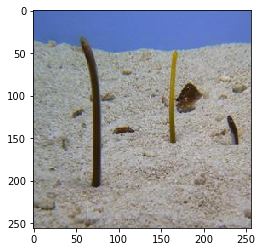

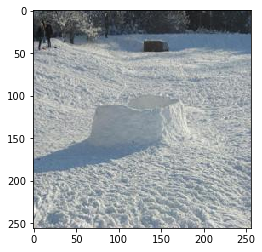

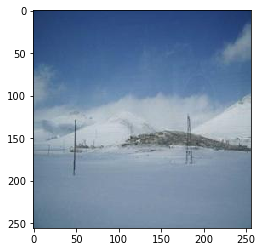

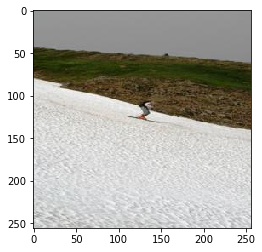

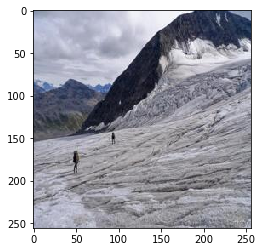

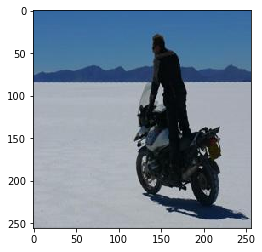

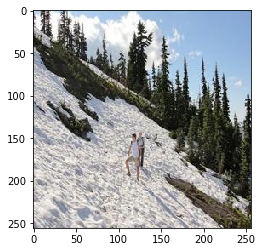

In [59]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print("\n"+color.BOLD + "Query image: " + color.END + "\n")
# img_path = os.path.join(img_directory, query_image)
img=mpimg.imread(query_image)
imgplot = plt.imshow(img)
plt.show()
print(color.BOLD + "Results:" + color.END + "\n")
for image in sorted_image_scores:
    img=mpimg.imread(image)
    imgplot = plt.imshow(img)
    plt.show()